In [147]:
#First out imports
#Lets import some stuff!
from datetime import datetime
import os
import tempfile
import cartopy.crs as ccrs
from boto.s3.connection import S3Connection
import cartopy
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import simple_layout, StationPlot, StationPlotLayout
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import pyart
import pytz
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import xarray
import netCDF4
import cartopy.io.img_tiles as cimgt


from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
%matplotlib inline

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:13:44.676652. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 17:23:09.054352. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [101]:
def plot_radar_ppi(radar, field = 'reflectivity', cmap=None,
               vmin=None, vmax=None, sweep=None, fig=None):

    if sweep is None:
        sweep = 0


    # Lets get some geographical context
    lats = radar.gate_latitude
    lons = radar.gate_longitude

    min_lon = lons['data'].min()
    min_lat = lats['data'].min()
    max_lat = lats['data'].max()
    max_lon = lons['data'].max()

    print('min_lat:', min_lat, ' min_lon:', min_lon,
          ' max_lat:', max_lat, ' max_lon:', max_lon)

    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start],
                                      radar.time['units'])
    GMT = pytz.timezone('GMT')
    local_time = GMT.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    print(fancy_date_string)
    if fig is None:
        fig = plt.figure(figsize = [15,10])
    display = pyart.graph.RadarMapDisplayCartopy(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]

    # Main difference! Cartopy forces you to select a projection first!
    projection = cartopy.crs.Mercator(
                    central_longitude=lon_0,
                    min_latitude=min_lat, max_latitude=max_lat)

    title = 'KIND ' + field.replace('_',' ') + ' \n' + fancy_date_string

    display.plot_ppi_map(
        field, sweep, colorbar_flag=False,
        title=title,
        projection=projection,
        min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
        vmin=vmin, vmax=vmax, cmap=cmap)

    lb = display._get_colorbar_label(field)
    cb = plt.colorbar(display.plots[0], shrink=.7, aspect=30, pad=0.01)
    cb.set_label(lb)

    # Mark the radar
    display.plot_point(lon_0, lat_0, label_text='KIND')

    # Plot some lat and lon lines
    gl = display.ax.gridlines(draw_labels=True,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 10:31:54.574970. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [135]:
# Lets grab the latest radar volume from Seattle
station = 'KAMX'
my_datetime = datetime.utcnow()
radar = get_radar_from_aws(station, my_datetime)

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:06:44.290544. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


min_lat: 21.4817862141  min_lon: -84.992777761  max_lat: 29.7403795023  max_lon: -75.8325334541
Friday July 14 at 03:58 PM GMT


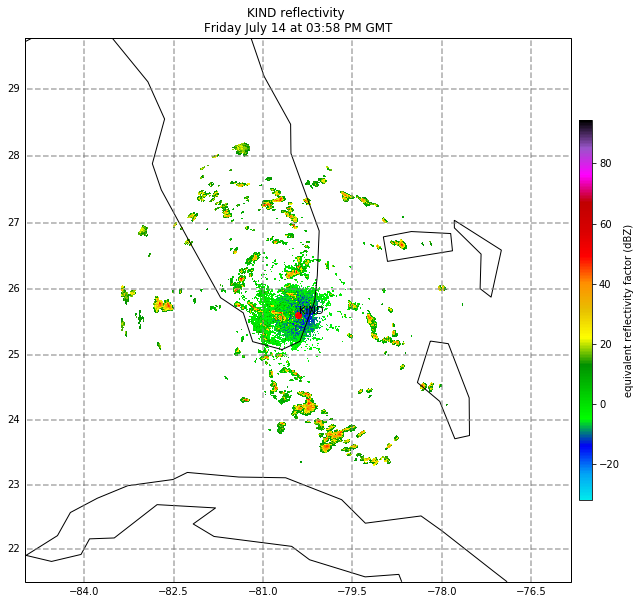

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:06:53.024591. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [136]:
plot_radar_ppi(radar, sweep=1)

In [137]:
speckles = pyart.correct.despeckle.despeckle_field(radar, 'reflectivity')

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:07:09.483082. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [158]:
grids = pyart.map.grid_from_radars(radar,(31,601,601),
                   ((0.,15000.),(-150000.,150000.),(-150000.,150000.)),
                   fields=list(radar.fields.keys()),
                   refl_field='reflectivity', gatefilters=(speckles,))

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:22:54.574461. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [159]:
long, lat = grids.get_point_longitude_latitude()
height = grids.point_z['data'][:,0,0]
time = np.array([ netCDF4.num2date(grids.time['data'][0], grids.time['units'])])

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:23:06.020676. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [171]:
ds = xarray.Dataset()
for this_field in list(grids.fields.keys()):
    this_data = grids.fields[this_field]['data']
    my_data = xarray.DataArray(np.expand_dims(this_data,0),
                               dims = ('time', 'z', 'y', 'x'),
                               coords = {'time' : (['time'], time),
                                         'z' : (['z'], height),
                                         'lat' :(['y','x'], lat),
                                         'lon' : (['y','x'],long),
                                          'y' : (['y'],lat[:,0]),
                                          'x' : (['x'],long[0,:])})
    
    for this_meta in list(grids.fields[this_field].keys()):
        if this_meta is not 'data':
            my_data.attrs.update({this_meta: grids.fields[this_field][this_meta]})
    
    ds[this_field] = my_data
    ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
             ('units', 'degrees_east')]
    ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
             ('units', 'degrees_north')]
    ds.z.attrs['long_name'] = "height above sea sea level"
    ds.z.attrs['units'] = "m"

    ds.z.encoding['_FillValue'] = None
    ds.lat.encoding['_FillValue'] = None
    ds.lon.encoding['_FillValue'] = None

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:41:10.225049. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/cartopy/img_transform.py:80: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


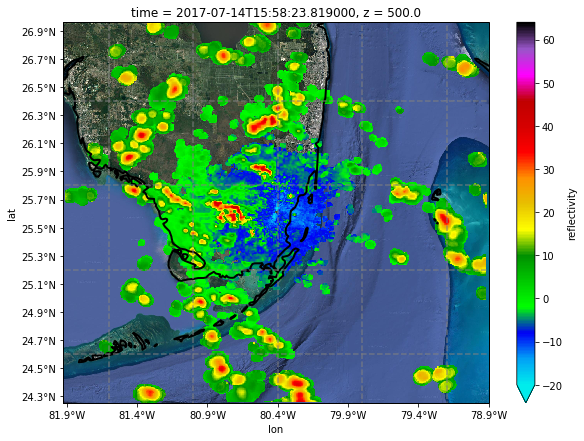

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:41:36.060029. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [173]:
lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), 
                      ds.lat.max(), .2)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=1),
                      ds.lon.max(), .5)

fig = plt.figure(figsize=[10,7])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

pc = ds.reflectivity[0].sel(z=500, method='nearest').plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef)

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)


extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]
my_ax.set_extent(extent)

request = cimgt.GoogleTiles(style='satellite')
my_ax.add_image(request, 10, zorder=0)

/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/cartopy/img_transform.py:80: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


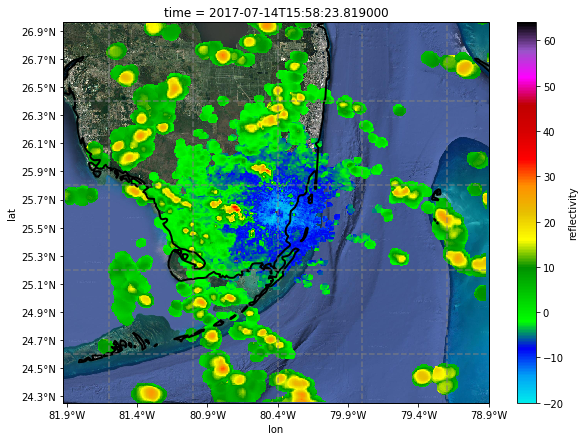

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:23:18.839546. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [163]:
lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), 
                      ds.lat.max(), .2)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=1),
                      ds.lon.max(), .5)

fig = plt.figure(figsize=[10,7])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

pc = ds.reflectivity[0].mean(dim='z').plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef)

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')


coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)


extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]
my_ax.set_extent(extent)

request = cimgt.GoogleTiles(style='satellite')
my_ax.add_image(request, 10, zorder=0)

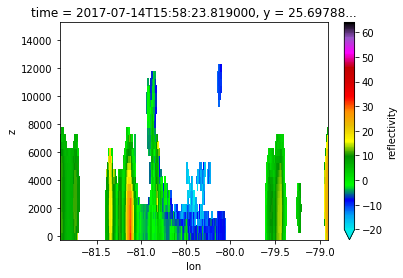

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:41:22.356153. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [172]:
pc = ds.reflectivity[0].sel(y=25.7, method='nearest').plot.pcolormesh(x='lon', y='z', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef)


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/cartopy/img_transform.py:80: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


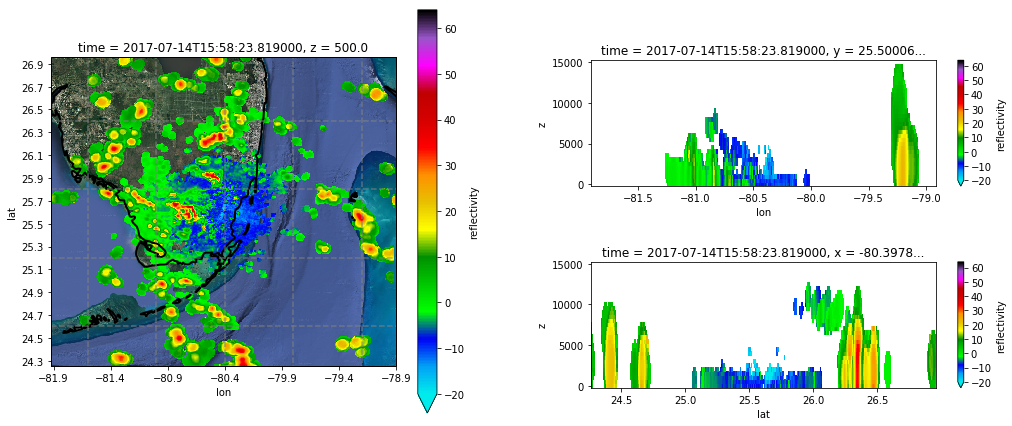

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-14 11:50:35.988788. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [175]:
lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), 
                      ds.lat.max(), .2)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=1),
                      ds.lon.max(), .5)


fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]


# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes, projection = ccrs.PlateCarree())

pc = ds.reflectivity[0].sel(z=500, method='nearest').plot.pcolormesh(transform=ccrs.PlateCarree(), 
                                                                     ax=ax1,
                                                                     x='lon', 
                                                                     y='lat', 
                                                                     vmin=-20,
                                                                     vmax=64, cmap=pyart.graph.cm.NWSRef)

ax1.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax1.set_yticks(lat_lines, crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=False,
                     linewidth=2, color='gray', 
                     alpha=0.5, linestyle='--')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

ax1.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)


extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]
ax1.set_extent(extent)

request = cimgt.GoogleTiles(style='satellite')
ax1.add_image(request, 10, zorder=0)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
pc = ds.reflectivity[0].sel(x=-80.4, method='nearest').plot.pcolormesh(x='lat', y='z', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef)


# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
pc = ds.reflectivity[0].sel(y=25.5, method='nearest').plot.pcolormesh(x='lon', y='z', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef)

